In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torchbones
from torchbones import Model, Net
import bones
from bones import Model
import torch
import torch.nn as nn
from torch import optim
import pandas as pd
import pickle
from sklearn.metrics import confusion_matrix

# Purpose
This module is designed to quickly set up and optimize a supervised neural network using 1d or 2d data. Here I will demonstrate how to use the network and show that it works on 1d and 2d data.

## Intializing the model with Model(*args)
#### Args:
      - lins: (list of integers) the widths of the linear layers. The length of this list defines the number of layers.
      - activation: the activation function to be applied after each linear layer. You can create your own (using pytorch rules), use a pytorch one, or pass None.
      - optimizer: a pytorch optimizer
      - batch_size: (int) number of samples to be trained on at a time
      - lr: (float) initial learning rate (can be decayed with lr_decay kwarg)
      - data: (array) can be 1d or 2d data. Data should be stacked along dim = 0. i.e. if you have 20 images size 3x3, your array should have shape (20, 3, 3). It will be split into train/validation automatically.
      -truth: (array) truth values
      - cost: cost function (custom or from pytorch)

## Import some sample data, in this case various qualities of wine as data and their ratings as truth

In [2]:
wines = pd.read_csv('winequality-red.csv', delimiter = ';').to_numpy()
truth = wines[:, -1]
data = wines[:, :-1]
data.shape

(1599, 11)

In [5]:
## Example using only necessary arguments
lins = [1000, 100, 10, 10, 4, 1]  #the last number should be the size of the output you want
activation = nn.PReLU ## set the activation function
optimizer = optim.SGD ## set the optimizer
batch_size = 100 ## set the batch size
init_lr = 5e-4 ## set the initial learning rate
cost = nn.MSELoss() ## set the cost function

#Initialize the model
model = Model(lins, activation, optimizer, batch_size, init_lr, data, truth, cost, test_set = np.random.randint(0, data.shape[0], 100),
              max_batch = 10 )

10


## Once the model is loaded, we can print it's parameters using model.params()
I will explain what all the parameters mean in due time

In [6]:
model.params()

,conv channels,conv kernel sizes,linear layer sizes,activation,Dropout,ResNet,training sample size,optimizer,batch size,initial learning rate,learning rate decay,learning rate,epochs,train loss,test loss
0,[],[],"[1000, 100, 10, 10, 4, 1]",PReLU,0,False,100,SGD,100,0.0005,1,0.0005,0,None,None


## Run it using model.run()
By default it will run for 20 epochs and print loss and a plot every 10 epochs.

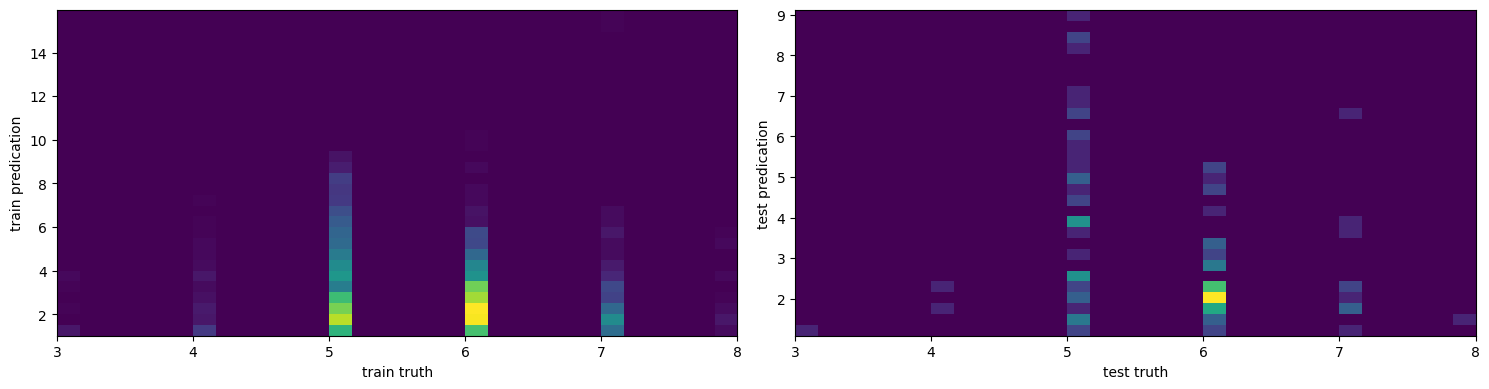

Epoch number 0:
 Test Loss: 10.566; Train Loss 14.245


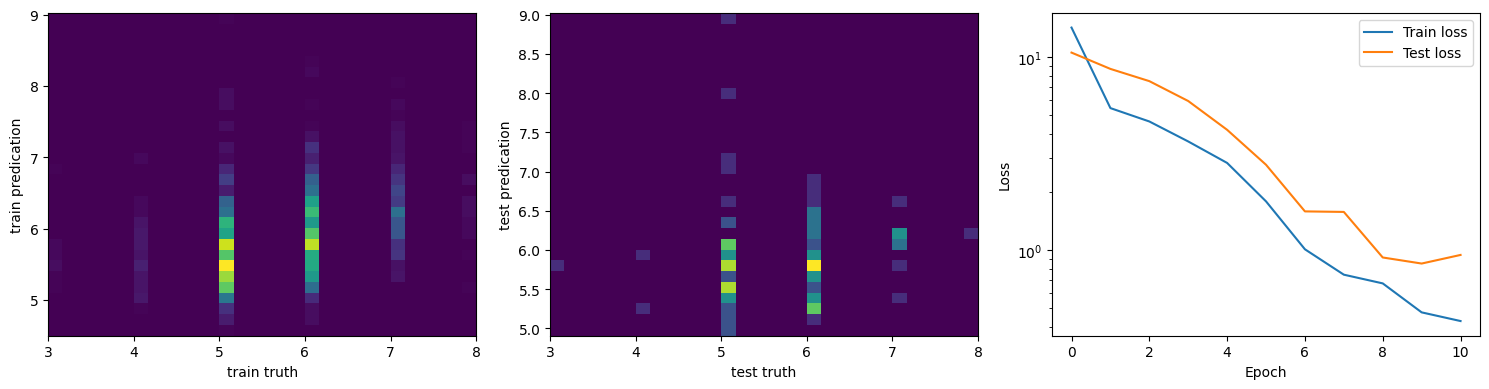

Epoch number 10:
 Test Loss: 0.943; Train Loss 0.428


In [7]:
model.run()

## if you run this again without re-initializing the model, it will pick up where you left off

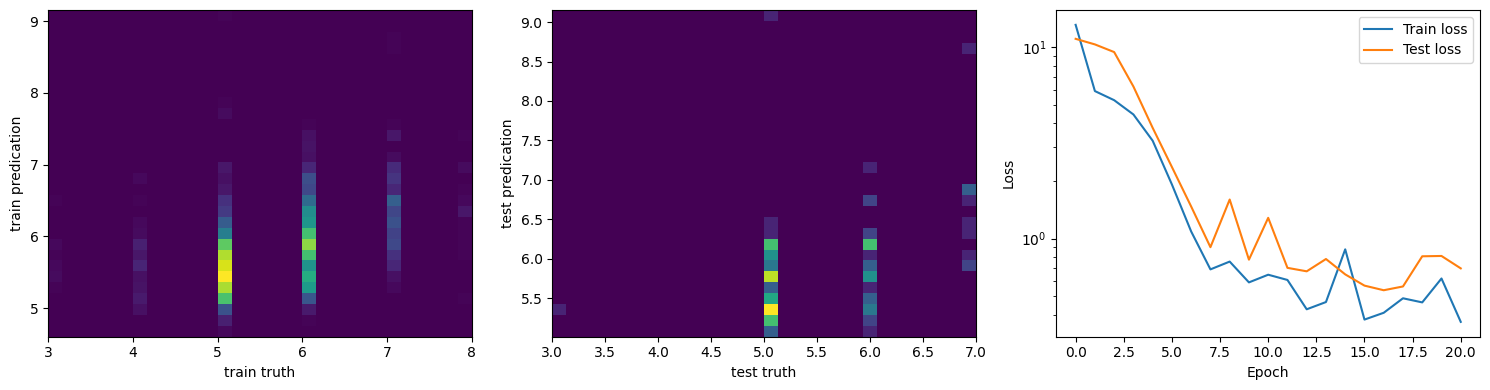

Epoch number 20:
 Test Loss: 0.698; Train Loss 0.367


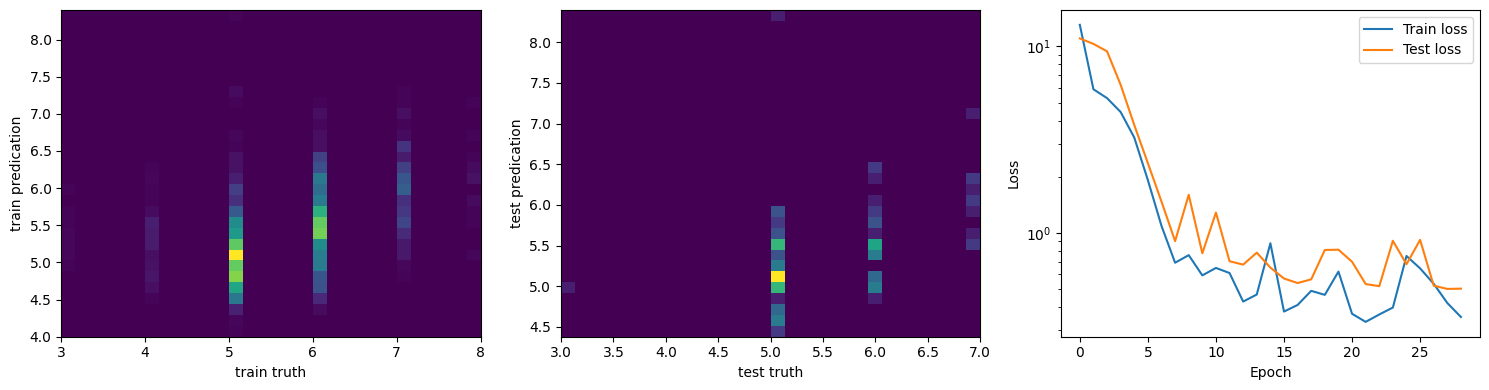

Epoch number 28:
 Test Loss: 0.501; Train Loss 0.353


In [6]:
model.run(epochs = 10, plot_ev = 8)  #you can specificy how many epochs to run for

## params will update with each epoch. You can see that train and test losses now have values for the most recent epoch

In [7]:
model.params()

,conv channels,conv kernel sizes,linear layer sizes,activation,Dropout,ResNet,training sample size,optimizer,batch size,initial learning rate,learning rate decay,learning rate,epochs,train loss,test loss
3,[],[],"[1000, 100, 10, 10, 4, 1]",PReLU,0,False,100,SGD,100,0.0005,1,0.0005,30,0.37,0.56


# 2D Data


## Image Data as inputs

### For 2d data (images) you can do convolutions.
    - csizes: (list, default []) sizes of the convolution kernels (should be odd)
    - convs: (list, default []) widths of the convolution layers, defines the number of convolution layers
    - (both convs and csizes must be included to do convolutions)
    -resnet: (bool, default False) More advanced and not as thoroughly tested, but if you want to use a residual network, set resnet = True (https://arxiv.org/abs/1512.03385)

(1D convolutions coming soon)

### so let's load some 2d data-- the fashion MNIST set in this case, which classifies images of clothing into 10 categories.

In [8]:
import tensorflow as tf
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
data = np.vstack((train_images, test_images))[:10000]
truth = np.append(train_labels, test_labels)[:10000]
#I've cut off the data at 10,000 samples

2023-06-09 12:49:04.787415: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-09 12:49:05.969586: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [9]:
activation = nn.Tanh
optimizer = optim.SGD
init_lr = 5e-2
lins = [1000,  100, 10]
cost = nn.CrossEntropyLoss() 
## Using Cross Entropy Loss for classification makes the plots into confusion matrices
model = Model(lins, activation, optimizer, batch_size, init_lr, data, truth, cost, 
             convs = [2, 2,], csizes = [3, 3,], max_batch = 10)
model.params()

10


,conv channels,conv kernel sizes,linear layer sizes,activation,Dropout,ResNet,training sample size,optimizer,batch size,initial learning rate,learning rate decay,learning rate,epochs,train loss,test loss
3,"[2, 2]","[3, 3]","[1000, 100, 10]",Tanh,0,False,2000,SGD,100,0.05,1,0.05,0,None,None


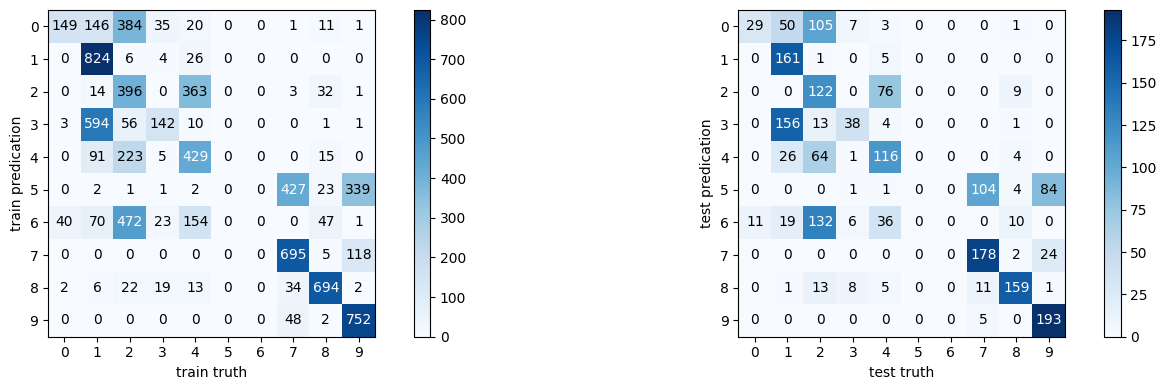

Epoch number 0:
 Test Loss: 1.908; Train Loss 0.268


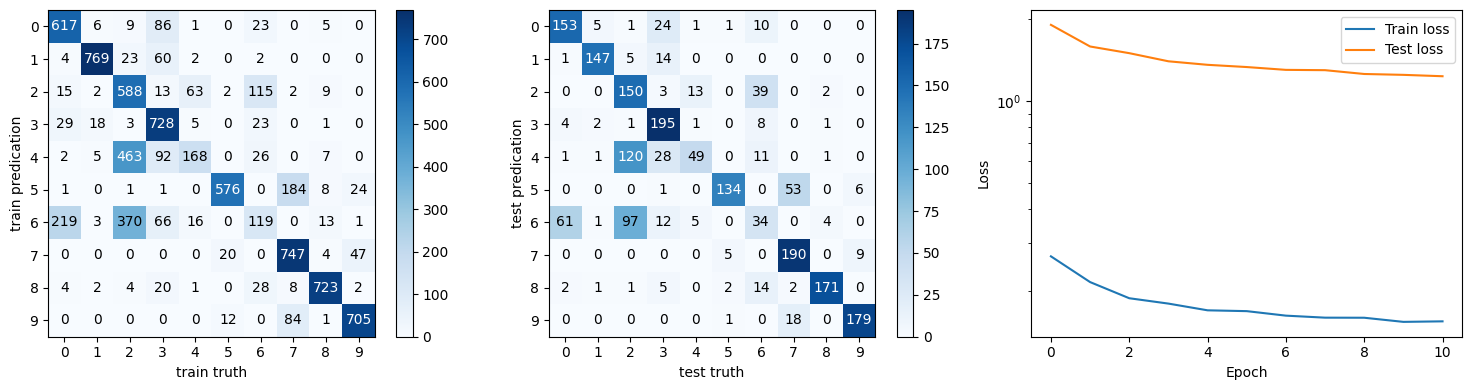

Epoch number 10:
 Test Loss: 1.234; Train Loss 0.155


In [10]:
model.run(epochs = 20, plot_ev = 10) #you can specify how often to plot results with plot_ev

### Dynamic learning rates
#### adjust the learning rate or learning rate decay
    - lr_decay: (float, default 1) learning rate decay factor. ex. if init_lr = .7 and lr_decay = .5, after 1 epoch the  learning rate will be lr = .7*.5 = .35. 
    -lr_min: (float, default 1e-8) minimum learning rate applied when decaying

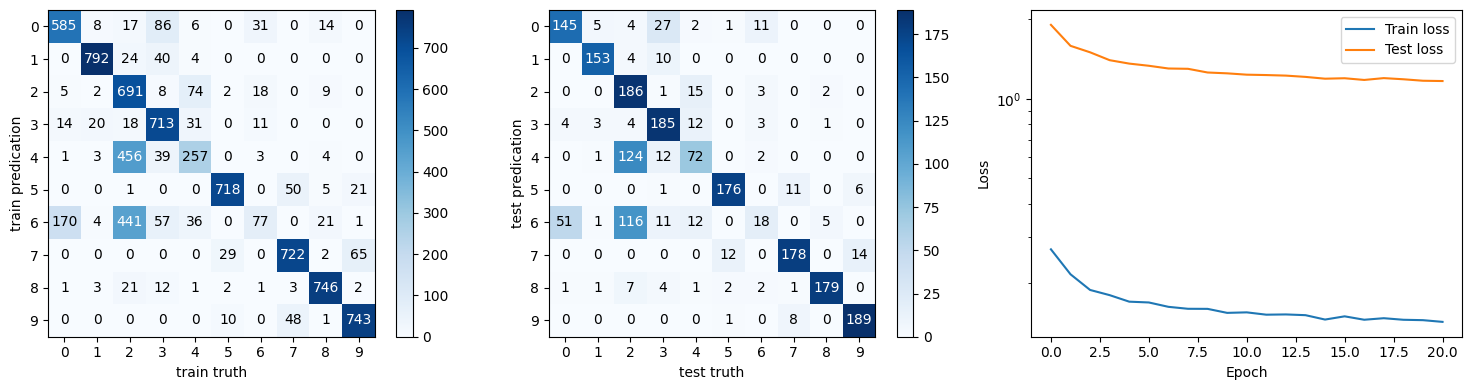

Epoch number 20:
 Test Loss: 1.168; Train Loss 0.142


In [11]:
model.run( lr_decay = .95, lr_min = 1e-8, epochs = 10)

### Saving
    One of the key elements of this system is that you can save past runs and compare their outcomes. 
    - saving: (bool, default False) When set to true, the params of a run will be saved to a pandas dataframe in 'params.p'
    - save_tar: (bool, default False) When set to true, the weights of the model will be saved to 'weights/X.tar' where X is the ID number corresponding to the saved parameters in params.p
    - run_num: (int, default None) set to the id number of a past run to load it's and pick up where it left off
    -new_tar: (bool, default False) set to True if you would like to load an old run (using run_num) but save the new results in a new file
        
    If you initialize a model with all the same parameters as a past run, you will get a warning.

In [12]:
truth = wines[:, -1]
data = wines[:, :-1]

init_lr = 1e-4
lins = [10, 1]
model = Model(lins, activation, optimizer, batch_size, init_lr, data, truth, nn.MSELoss(),
              lr_decay = .9, saving = True, save_weights = True)
model.params()

,conv channels,conv kernel sizes,linear layer sizes,activation,Dropout,ResNet,training sample size,optimizer,batch size,initial learning rate,learning rate decay,learning rate,epochs,train loss,test loss
2,[],[],"[10, 1]",Tanh,0,False,320,SGD,100,0.0001,0.9,0.000059,4,21.82,22.28


saving weights to weights/3.tar
12


/home/oross314/torch_template/bones.py:215: UserWarning: Run(s) [2.] used the same hyper parameters
  warnings.warn('Run(s) '+ str(same) + ' used the same hyper parameters')


,conv channels,conv kernel sizes,linear layer sizes,activation,Dropout,ResNet,training sample size,optimizer,batch size,initial learning rate,learning rate decay,learning rate,epochs,train loss,test loss
3,[],[],"[10, 1]",Tanh,0,False,320,SGD,100,0.0001,0.9,0.0001,0,None,None


## I will now let it run for a few epochs, re-initialize the model and load the weights from the previous run.

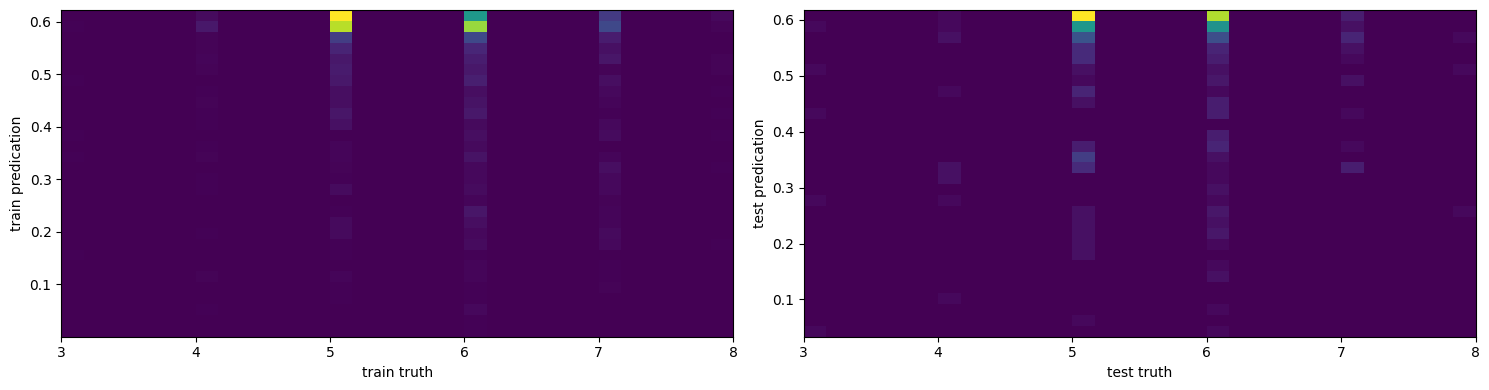

Epoch number 0:
 Test Loss: 25.791; Train Loss 26.611


In [13]:
model.run(epochs = 5)

In [14]:
pickle.load(open('params.p', 'rb'))

,conv channels,conv kernel sizes,linear layer sizes,activation,Dropout,ResNet,training sample size,optimizer,batch size,initial learning rate,learning rate decay,learning rate,epochs,train loss,test loss
0,[],[],"[1000, 100, 10, 10, 4, 1]",PReLU,0,False,100,SGD,100,0.0005,1.0,0.000500,0,NaN,NaN
1,[],[],"[10, 1]",Tanh,0,False,320,SGD,100,0.0001,1.0,0.000059,42,21.59,22.01
2,[],[],"[10, 1]",Tanh,0,False,320,SGD,100,0.0001,0.9,0.000059,4,21.82,22.28
3,[],[],"[10, 1]",Tanh,0,False,320,SGD,100,0.0001,0.9,0.000059,4,23.47,23.96


In [15]:
model = Model(lins, activation, optimizer, batch_size, init_lr, data, truth, nn.MSELoss(),
              saving = True, run_num = 1)
model.params()

Weights from run  1  loaded.
12


,conv channels,conv kernel sizes,linear layer sizes,activation,Dropout,ResNet,training sample size,optimizer,batch size,initial learning rate,learning rate decay,learning rate,epochs,train loss,test loss
1,[],[],"[10, 1]",Tanh,0,False,320,SGD,100,0.0001,1,0.000059,42,None,None


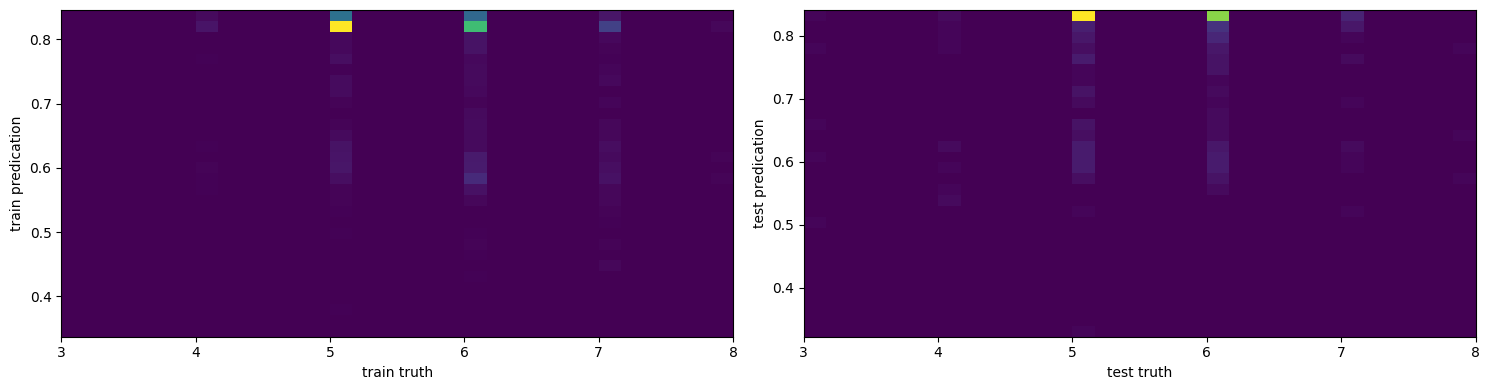

Epoch number 42:
 Test Loss: 23.282; Train Loss 22.996


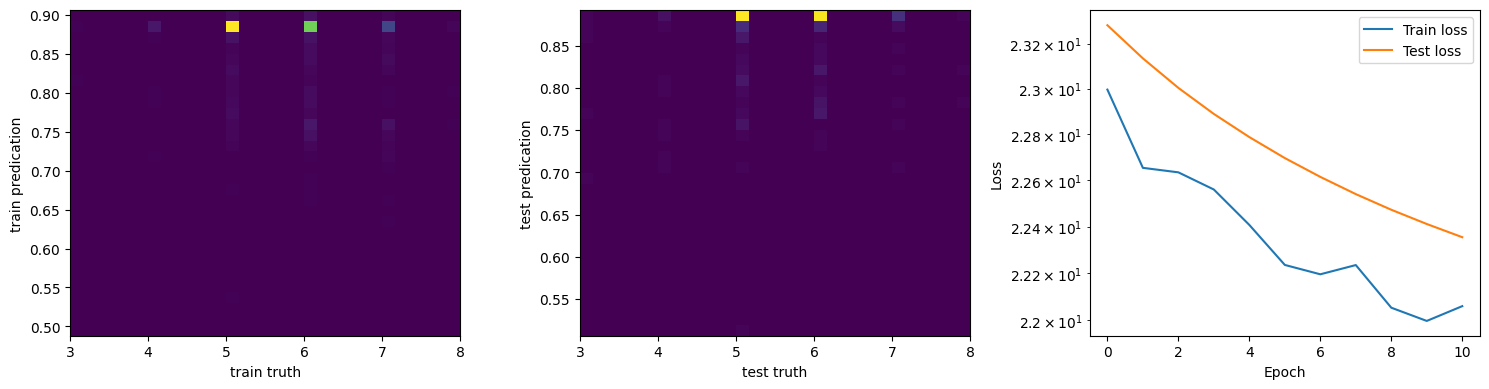

Epoch number 52:
 Test Loss: 22.354; Train Loss 22.06


In [16]:

model.run()

## Other
    -There are a few other kwargs I have not mentioned: 
        -train_frac: (float, default .8) fraction of the datset to be used for training
        -test_set: (array or list) indices of the data to be used as the test data
        -max_batch: (int, default None) can specify a maximum number of batches per epoch if you don't want
                    to use all training data in each epoch
        -training: (bool) if turned off, model will load and plot but will not change weights
    - Learning rate kwargs ('lr', 'lr_decay', 'lr_min',) can be changed in both the model initialization and as a kwarg in model.run() so you can them change mid-run.